This notebook is concerned with Pitchers, and runs parallel to Baseball Data Preparation notebook.

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

from sklearn.metrics import mean_squared_error

seasonBase = 5

### Win Shares Data

In [2]:
WS_df = pd.read_csv("db/WinShares.csv")
WS_df.head(10)

,playerID,yearID,year WS
0,aaronha01,1954,13
1,aaronha01,1955,29
2,aaronha01,1956,30
3,aaronha01,1957,35
4,aaronha01,1958,32
5,aaronha01,1959,38
6,aaronha01,1960,35
7,aaronha01,1961,35
8,aaronha01,1962,34
9,aaronha01,1963,41


In [3]:
# summarize by career as well
WS_Career_df = WS_df.groupby(["playerID"],as_index=False).sum()
del WS_Career_df["yearID"]


In [4]:
WS_Career_df = WS_Career_df.rename(
    columns={"year WS":"careerWS"})

WS_Career_df.columns

Index(['playerID', 'careerWS'], dtype='object')

### Pitching Data  
This will be the source of our statistics.

In [5]:
pitching_df = pd.read_csv("db/Pitching.csv")

Since we aren't concerned about per-team statistics, let's combine all multiple-stint years into one row.

In [6]:
pitching_df = pitching_df.groupby(["playerID","yearID"],as_index=False).sum()
pitching_df.head(10)

,playerID,yearID,stint,W,L,G,GS,CG,SHO,SV,...,IBB,WP,HBP,BK,BFP,GF,R,SH,SF,GIDP
0,aardsda01,2004,1,1,0,11,0,0,0,0,...,0.0,0,2.0,0,61.0,5,8,0.0,1.0,1.0
1,aardsda01,2006,1,3,0,45,0,0,0,0,...,0.0,1,1.0,0,225.0,9,25,1.0,3.0,2.0
2,aardsda01,2007,1,2,1,25,0,0,0,0,...,3.0,2,1.0,0,151.0,7,24,2.0,1.0,1.0
3,aardsda01,2008,1,4,2,47,0,0,0,0,...,2.0,3,5.0,0,228.0,7,32,3.0,2.0,4.0
4,aardsda01,2009,1,3,6,73,0,0,0,38,...,3.0,2,0.0,0,296.0,53,23,2.0,1.0,2.0
5,aardsda01,2010,1,0,6,53,0,0,0,31,...,5.0,2,2.0,0,202.0,43,19,7.0,1.0,5.0
6,aardsda01,2012,1,0,0,1,0,0,0,0,...,0.0,0,0.0,0,5.0,1,1,0.0,0.0,0.0
7,aardsda01,2013,1,2,2,43,0,0,0,0,...,6.0,1,4.0,1,178.0,7,20,2.0,1.0,2.0
8,aardsda01,2015,1,1,1,33,0,0,0,0,...,3.0,1,1.0,0,129.0,9,17,0.0,1.0,4.0
9,aasedo01,1977,1,6,2,13,13,4,2,0,...,1.0,0,1.0,0,373.0,0,36,2.0,3.0,7.0


But first, one more thing.  We'll use Games to determine players' most dominent decade.

In [7]:
decades_df = pitching_df[["playerID", "yearID", "G"]]

In [8]:
x = decades_df.loc[:, "yearID"] / 10
decades_df.loc[:, "decade"] = 10 * x.round()
decades_df.head()

C:\Users\Laptop 1\Anaconda3\lib\site-packages\pandas\core\indexing.py:362: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[key] = _infer_fill_value(value)
C:\Users\Laptop 1\Anaconda3\lib\site-packages\pandas\core\indexing.py:543: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s


,playerID,yearID,G,decade
0,aardsda01,2004,11,2000.0
1,aardsda01,2006,45,2010.0
2,aardsda01,2007,25,2010.0
3,aardsda01,2008,47,2010.0
4,aardsda01,2009,73,2010.0


In [9]:
decades_df = decades_df.groupby(["playerID", "decade"], as_index=False).sum()
decades_df.head()

,playerID,decade,yearID,G
0,aardsda01,2000.0,2004,11
1,aardsda01,2010.0,14065,287
2,aardsda01,2020.0,2015,33
3,aasedo01,1980.0,15846,259
4,aasedo01,1990.0,9940,189


In [10]:
decades_df = decades_df.sort_values(["playerID","G"], ascending=[True, False]).reset_index()
decades_df.head()

,index,playerID,decade,yearID,G
0,1,aardsda01,2010.0,14065,287
1,2,aardsda01,2020.0,2015,33
2,0,aardsda01,2000.0,2004,11
3,3,aasedo01,1980.0,15846,259
4,4,aasedo01,1990.0,9940,189


Keep the first occurance of each player.  Having sorted the data in descending order of at bats, that would be the player's dominant decade.

In [11]:
decades = []
names = []
prevname = ''
for index, player in decades_df.iterrows():
    if player["playerID"] != prevname:
        names.append(player["playerID"])
        decades.append(player["decade"])
        prevname=player["playerID"]
      
decades2_dict = {"playerID": names,
                  "decade": decades}
decades2_df = pd.DataFrame(decades2_dict)
        

In [12]:
decades2_df.head(10)

,playerID,decade
0,aardsda01,2010.0
1,aasedo01,1980.0
2,abadfe01,2010.0
3,abbeybe01,1890.0
4,abbeych01,1900.0
5,abbotda01,1890.0
6,abbotgl01,1980.0
7,abbotji01,1990.0
8,abbotky01,1990.0
9,abbotpa01,2000.0


Oh, and one more thing.  We need to know the last year a player was active, so that we know if they are even eligible for the Hall of Fame.

In [13]:
years_df = pitching_df[["playerID", "yearID"]]
# drop duplicates that exist because a player might play for more than one team in any given year
years_df = years_df.drop_duplicates()
lastyear_df = years_df.groupby(["playerID"], as_index=False).max(axis="yearID")
lastyear_df = lastyear_df.rename(columns={"yearID":"lastyear"})
lastyear_df.head(20)

,playerID,lastyear
0,aardsda01,2015
1,aasedo01,1990
2,abadfe01,2017
3,abbeybe01,1896
4,abbeych01,1896
5,abbotda01,1890
6,abbotgl01,1984
7,abbotji01,1999
8,abbotky01,1996
9,abbotpa01,2004


In [14]:
# also need number of seasons
numyear_df = years_df.groupby(["playerID"], as_index=False).count()
numyear_df = numyear_df.rename(columns={"yearID":"numyears"})
numyear_df.head(15)

,playerID,numyears
0,aardsda01,9
1,aasedo01,13
2,abadfe01,8
3,abbeybe01,5
4,abbeych01,1
5,abbotda01,1
6,abbotgl01,11
7,abbotji01,10
8,abbotky01,4
9,abbotpa01,11


### Now, it's time to put it all together

In [15]:
pitching_df = pd.merge(pitching_df, WS_df, on=["playerID", "yearID"], how="left")
pitching_df = pd.merge(pitching_df, WS_Career_df, on="playerID", how="left")
pitching_df = pd.merge(pitching_df, decades2_df, on="playerID", how="left")
pitching_df = pd.merge(pitching_df, lastyear_df, on="playerID", how="left")
pitching_df = pd.merge(pitching_df, numyear_df, on="playerID", how="left")


In [16]:
pitching_df.columns

Index(['playerID', 'yearID', 'stint', 'W', 'L', 'G', 'GS', 'CG', 'SHO', 'SV',
       'IPouts', 'H', 'ER', 'HR', 'BB', 'SO', 'BAOpp', 'ERA', 'IBB', 'WP',
       'HBP', 'BK', 'BFP', 'GF', 'R', 'SH', 'SF', 'GIDP', 'year WS',
       'careerWS', 'decade', 'lastyear', 'numyears'],
      dtype='object')

Now we start cutting back players we won't be considering.


In [17]:
# discard players from early eras
pitching2_df = pitching_df.loc[pitching_df["decade"] > 1910, :]

In [18]:
# fewer than five years would not be enough data to judge a player
pitching2_df = pitching2_df.loc[pitching_df["numyears"] > 5, :]

In [19]:
# discard low-impact players
pitching2_df = pitching2_df.loc[pitching_df["careerWS"] > 50, :]

In [20]:
pitching2_df["wsPerYr"] = pitching2_df["careerWS"] / pitching2_df["numyears"]

In [21]:
pitching2_df = pitching2_df.loc[pitching2_df["wsPerYr"] > 10, :]

In [22]:
pitching2_df.head(5)

,playerID,yearID,stint,W,L,G,GS,CG,SHO,SV,...,R,SH,SF,GIDP,year WS,careerWS,decade,lastyear,numyears,wsPerYr
187,adamsba01,1906,1,0,1,1,1,0,0,0,...,8,0.0,0.0,0.0,0.0,243.0,1920.0,1926,19,12.789474
188,adamsba01,1907,1,0,2,4,3,1,0,0,...,25,0.0,0.0,0.0,0.0,243.0,1920.0,1926,19,12.789474
189,adamsba01,1909,1,12,3,25,12,7,3,2,...,25,0.0,0.0,0.0,16.0,243.0,1920.0,1926,19,12.789474
190,adamsba01,1910,1,18,9,34,30,16,3,0,...,95,0.0,0.0,0.0,21.0,243.0,1920.0,1926,19,12.789474
191,adamsba01,1911,1,22,12,40,37,24,6,0,...,97,0.0,0.0,0.0,25.0,243.0,1920.0,1926,19,12.789474


In [23]:
pitching2_df.columns

Index(['playerID', 'yearID', 'stint', 'W', 'L', 'G', 'GS', 'CG', 'SHO', 'SV',
       'IPouts', 'H', 'ER', 'HR', 'BB', 'SO', 'BAOpp', 'ERA', 'IBB', 'WP',
       'HBP', 'BK', 'BFP', 'GF', 'R', 'SH', 'SF', 'GIDP', 'year WS',
       'careerWS', 'decade', 'lastyear', 'numyears', 'wsPerYr'],
      dtype='object')

In [24]:
# drop columns which are no longer needed

del pitching2_df ["stint"]
del pitching2_df ["CG"]
del pitching2_df ["SHO"]
del pitching2_df ["SV"]  
# I think there are not enough relief pitchers in the HOF yet to create a reliable model, and they
# would need to be modelled somewhat differently than starting pitchers anyway.
del pitching2_df ["HR"]
del pitching2_df ["BAOpp"]
del pitching2_df ["IBB"]
del pitching2_df ["WP"]
del pitching2_df ["HBP"]
del pitching2_df ["BK"]
del pitching2_df ["BFP"]
del pitching2_df ["GF"]
del pitching2_df ["R"]
del pitching2_df ["SH"]
del pitching2_df ["SF"]
del pitching2_df ["GIDP"]

Recognize seasonal accomplishments by awarding points for meeting certain thresholds

In [25]:
p_wins = []
p_k    = []
p_pct  = []
p_era  = []

for index, player in pitching2_df.iterrows():
    px_wins = 0
    px_k    = 0
    px_pct  = 0
    px_era  = 0
    
    player_wins = pd.to_numeric(player["W"], errors="coerce")
    player_k    = pd.to_numeric(player["SO"], errors="coerce")
    player_era  = pd.to_numeric(player["ERA"], errors="coerce")

    
    if player_wins > 29:
        px_wins = 15
    elif player_wins > 24:
        px_wins = 10
    elif player_wins > 22:
        px_wins = 8
    elif player_wins > 19:
        px_wins = 6
    elif player_wins > 17:
        px_wins = 4
    elif player_wins > 14:
        px_wins = 2

        
    if player_k > 299:
        px_k = 6
    elif player_k > 249:
        px_k = 3
    elif player_k > 199:
        px_k = 2
        
    if player_wins  > 13:
        player_pct  = player["W"]/(player["W"]+player["L"])
        if player_pct >= .7:
            px_pct  = 2
            
    if player["IPouts"] >= 450:
        if player_era < 2:
            px_era = 4
        elif player_era < 3:
            px_era = 1
 
    p_wins.append(px_wins)
    p_k.append(px_k)
    p_pct.append(px_pct)
    p_era.append(px_era)
    
pitching2_df["pts_wins"] = p_wins
pitching2_df["pts_k"] = p_k
pitching2_df["pts_pct"] = p_pct
pitching2_df["pts_era"] = p_era


In [26]:
pitching2_df.to_csv("db/pitching2new.csv", index=False, header=True)

What we are doing now is to find and keep the first 7 "significant" seasons for each pitcher.

In [27]:
# Dennis Eckersly was half a starting pitcher and half a relief pitcher.  I have no idea how he would fit into this modeling.
pitching2_df = pitching2_df.loc[pitching2_df["playerID"] != "eckerde01", :]
# Also, Babe Ruth is not in the Hall Of Fame because of his pitching
pitching2_df = pitching2_df.loc[pitching2_df["playerID"] != "ruthba01", :]

In [28]:
# for a season to be "significant", the pitcher must have over 90 innings pitched
pitching2_df = pitching2_df.loc[pitching2_df["IPouts"] > 269, :]

In [29]:
# for the time being, we are skipping relief specialists.  Likely they have different parameters of excelence, and for 
# now there are only eight of them in the Hall of Fame.
# Require at least 25% of games in a season to be games started.
pitching2_df["GGSratio"] = pitching2_df["GS"] / pitching2_df["G"]
pitching2_df = pitching2_df.loc[pitching2_df["GGSratio"] >= .25, :]

In [30]:
pitching2_df = pitching2_df.sort_values(["playerID", "yearID"], ascending=[True,True])

In [31]:
season_num = []
prev_playerID = " "
for index, player in pitching2_df.iterrows():
    if player["playerID"] == prev_playerID:
        season += 1
    else:
        prev_playerID = player["playerID"]
        season = 1
          
    season_num.append(season)
            
pitching2_df["seasonNum"] = season_num
pitching2_df = pitching2_df.loc[pitching2_df["seasonNum"] <= seasonBase, :]

Summarize the pitching data into player data

In [32]:
pitching3_df = pitching2_df.groupby(["playerID"],as_index=False).sum()
pitching3_df.head(10)

,playerID,yearID,W,L,G,GS,IPouts,H,ER,BB,...,decade,lastyear,numyears,wsPerYr,pts_wins,pts_k,pts_pct,pts_era,GGSratio,seasonNum
0,adamsba01,9555,84,42,170,137,3457,998,283,209,...,9600.0,9630,95,63.947368,16,0,0,4,3.897818,15
1,aldrivi01,9620,72,56,158,148,3369,1179,452,350,...,9600.0,9640,45,56.666667,8,0,0,0,4.677778,15
2,alexado01,9865,38,39,143,70,1863,606,239,190,...,9900.0,9945,95,50.526316,0,0,0,0,2.603327,15
3,alexape01,9565,127,63,236,188,5145,1442,442,449,...,9600.0,9650,100,119.000000,45,6,4,8,3.980890,15
4,allenjo02,9673,80,28,141,119,2879,873,378,378,...,9700.0,9720,65,55.769231,12,0,4,1,4.290808,15
5,antonjo02,9767,70,55,171,143,3071,906,335,364,...,9800.0,9805,60,60.833333,12,0,2,2,4.014759,15
6,appieke01,9960,65,40,153,142,2986,871,327,327,...,10000.0,10020,80,58.750000,6,0,0,3,4.661765,15
7,aukerel01,9680,74,49,180,130,3086,1144,481,353,...,9700.0,9710,50,60.000000,8,0,2,0,3.708165,15
8,bagbyji01,9590,104,68,225,165,4337,1400,414,341,...,9600.0,9615,45,77.222222,29,0,2,8,3.712443,15
9,barneje01,9593,79,69,206,151,3915,1247,385,222,...,9600.0,9635,65,60.000000,18,0,2,4,3.652240,15


In [33]:
# no longer needed, and their sums would not make sense any way
del pitching3_df["yearID"]
del pitching3_df["seasonNum"]
del pitching3_df["GGSratio"]
del pitching3_df["decade"]
del pitching3_df['numyears']
del pitching3_df["wsPerYr"]

In [34]:
pitching3_df.columns

Index(['playerID', 'W', 'L', 'G', 'GS', 'IPouts', 'H', 'ER', 'BB', 'SO', 'ERA',
       'year WS', 'careerWS', 'lastyear', 'pts_wins', 'pts_k', 'pts_pct',
       'pts_era'],
      dtype='object')

In [35]:
# computed fields must be re-computed - their sums wouldn't make any sense
pitching3_df["ERA"]  = 9 * pitching3_df["ER"]/(pitching3_df["IPouts"]/3)
# I'd like to see what effect WHIP has, although I suspect it will be found to be highly correlated
# this is not a statistic that earlier HOF voters would have been aware of, and yet they may have been
# aware of it on a subliminal level
pitching3_df["WHIP"] = (pitching3_df["H"]+pitching3_df["BB"])/(pitching3_df["IPouts"]/3)
pitching3_df["PCT"]  = pitching3_df["W"]/(pitching3_df["W"]+pitching3_df["L"])

At this point, introduce data to identify players as being in the Hall Of Fame or not

In [36]:
HOF_df = pd.read_csv("db/HallOfFame.csv")
HOF_df.head()

,playerID,yearID,votedBy,ballots,needed,votes,inducted,category,needed_note
0,cobbty01,1936,BBWAA,226.0,170.0,222.0,Y,Player,NaN
1,ruthba01,1936,BBWAA,226.0,170.0,215.0,Y,Player,NaN
2,wagneho01,1936,BBWAA,226.0,170.0,215.0,Y,Player,NaN
3,mathech01,1936,BBWAA,226.0,170.0,205.0,Y,Player,NaN
4,johnswa01,1936,BBWAA,226.0,170.0,189.0,Y,Player,NaN


In [37]:
# unsuccessful votes are irrelevant for our purposes
HOF_subset1_df = HOF_df.loc[HOF_df["inducted"] == "Y", :]

# consider only those elected as players.  Some players were elected as managers.
HOF_subset2_df = HOF_subset1_df.loc[HOF_subset1_df["category"] == "Player", :]

# exclude any players elected from the Negro Leagues.  These are not likely to have relevant MLB statistics
HOF_subset3_df = HOF_subset2_df.loc[HOF_subset2_df["votedBy"] != "Negro League", :]


# discard unneeded columns
xyz = ["playerID","inducted"]
HOF_df = HOF_subset3_df[xyz]
HOF_df.head()

,playerID,inducted
0,cobbty01,Y
1,ruthba01,Y
2,wagneho01,Y
3,mathech01,Y
4,johnswa01,Y


In [38]:
pitching3_df = pd.merge(pitching3_df, HOF_df, on="playerID", how="left")

In [39]:
pitching3_df.head(30)

,playerID,W,L,G,GS,IPouts,H,ER,BB,SO,...,year WS,careerWS,lastyear,pts_wins,pts_k,pts_pct,pts_era,WHIP,PCT,inducted
0,adamsba01,84,42,170,137,3457,998,283,209,506,...,104.0,1215.0,9630,16,0,0,4,1.047440,0.666667,NaN
1,aldrivi01,72,56,158,148,3369,1179,452,350,353,...,80.0,510.0,9640,8,0,0,0,1.361532,0.562500,NaN
2,alexado01,38,39,143,70,1863,606,239,190,228,...,31.0,960.0,9945,0,0,0,0,1.281804,0.493506,NaN
3,alexape01,127,63,236,188,5145,1442,442,449,1036,...,154.0,2380.0,9650,45,6,4,8,1.102624,0.668421,Y
4,allenjo02,80,28,141,119,2879,873,378,378,593,...,82.0,725.0,9720,12,0,4,1,1.303578,0.740741,NaN
5,antonjo02,70,55,171,143,3071,906,335,364,619,...,87.0,730.0,9805,12,0,2,2,1.240638,0.560000,NaN
6,appieke01,65,40,153,142,2986,871,327,327,766,...,87.0,940.0,10020,6,0,0,3,1.203617,0.619048,NaN
7,aukerel01,74,49,180,130,3086,1144,481,353,334,...,73.0,600.0,9710,8,0,2,0,1.455282,0.601626,NaN
8,bagbyji01,104,68,225,165,4337,1400,414,341,362,...,125.0,695.0,9615,29,0,2,8,1.204289,0.604651,NaN
9,barneje01,79,69,206,151,3915,1247,385,222,373,...,84.0,780.0,9635,18,0,2,4,1.125670,0.533784,NaN


We will need to convert the "inducted" to 1s and 0s

In [40]:
pitching3_df["HOF_member"] = np.where(pitching3_df["inducted"] == "Y",1,0)
pitching3_df.head(15)

,playerID,W,L,G,GS,IPouts,H,ER,BB,SO,...,careerWS,lastyear,pts_wins,pts_k,pts_pct,pts_era,WHIP,PCT,inducted,HOF_member
0,adamsba01,84,42,170,137,3457,998,283,209,506,...,1215.0,9630,16,0,0,4,1.047440,0.666667,NaN,0
1,aldrivi01,72,56,158,148,3369,1179,452,350,353,...,510.0,9640,8,0,0,0,1.361532,0.562500,NaN,0
2,alexado01,38,39,143,70,1863,606,239,190,228,...,960.0,9945,0,0,0,0,1.281804,0.493506,NaN,0
3,alexape01,127,63,236,188,5145,1442,442,449,1036,...,2380.0,9650,45,6,4,8,1.102624,0.668421,Y,1
4,allenjo02,80,28,141,119,2879,873,378,378,593,...,725.0,9720,12,0,4,1,1.303578,0.740741,NaN,0
5,antonjo02,70,55,171,143,3071,906,335,364,619,...,730.0,9805,12,0,2,2,1.240638,0.560000,NaN,0
6,appieke01,65,40,153,142,2986,871,327,327,766,...,940.0,10020,6,0,0,3,1.203617,0.619048,NaN,0
7,aukerel01,74,49,180,130,3086,1144,481,353,334,...,600.0,9710,8,0,2,0,1.455282,0.601626,NaN,0
8,bagbyji01,104,68,225,165,4337,1400,414,341,362,...,695.0,9615,29,0,2,8,1.204289,0.604651,NaN,0
9,barneje01,79,69,206,151,3915,1247,385,222,373,...,780.0,9635,18,0,2,4,1.125670,0.533784,NaN,0


In [41]:
pitching3_df.columns

Index(['playerID', 'W', 'L', 'G', 'GS', 'IPouts', 'H', 'ER', 'BB', 'SO', 'ERA',
       'year WS', 'careerWS', 'lastyear', 'pts_wins', 'pts_k', 'pts_pct',
       'pts_era', 'WHIP', 'PCT', 'inducted', 'HOF_member'],
      dtype='object')

Columns with high correlation should not both be used.

In [42]:
pd.options.display.float_format = '{:,.2f}'.format

In [43]:
# create a work dataframe that will make seeing correlations a little easier
work_df = pitching3_df[[ "W", "SO", "PCT", "ERA", "G","WHIP", "pts_wins", "pts_k", "pts_pct", "pts_era"]]

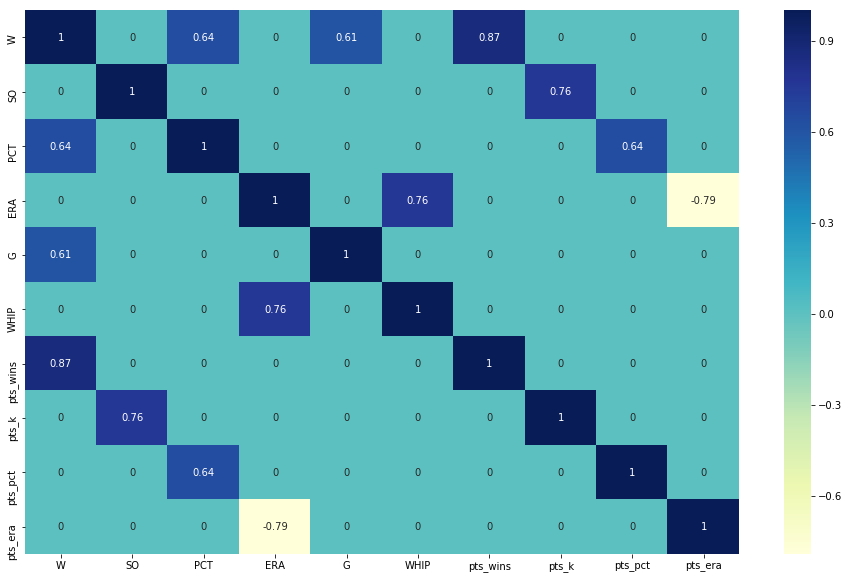

In [44]:
corr_matrix = work_df.corr()
corr_matrix[np.abs(corr_matrix) < .6] = 0      # masking lower correlations helps higher ones to stand out

plt.figure(figsize=(16,10))
sns.heatmap(corr_matrix, annot=True, cmap='YlGnBu')
plt.show()

Unsurprisingly, all representations of seasonal accomplishments (pts_x) have a high correlation with their corresponding career fields, just as they did with batting statistics.  So they can be discarded.

That leaves us with six stats:  Games, Wins, Strikeouts, Winning Percent, Earned Run Average, and Walks/Hits per Inning Pitched. We are finding WHIP with a high correlation to Strikeouts and ERA, so it can be eliminated.  Wins has a high correlation to Pct and Games; I'd say proceed with caution on these.

-----
With that, we can cut down again on the number of columns we need to keep.  With a change this big, we'll move to the next generation (batting4),

In [45]:
xyz = ["playerID","G", "W", "SO","PCT", "ERA", "WHIP", "HOF_member"]
pitching4_df = pitching3_df[xyz]
pitching4_df.head()

,playerID,G,W,SO,PCT,ERA,WHIP,HOF_member
0,adamsba01,170,84,506,0.67,2.21,1.05,0
1,aldrivi01,158,72,353,0.56,3.62,1.36,0
2,alexado01,143,38,228,0.49,3.46,1.28,0
3,alexape01,236,127,1036,0.67,2.32,1.10,1
4,allenjo02,141,80,593,0.74,3.54,1.30,0


"lastyear" was polluted by being summed, but we still need it for one more thing.  Merge it back in from when it was last good, that being in pitching2.

In [46]:
pitchingx_df = pitching2_df[["playerID","lastyear"]]
pitchingx_df.drop_duplicates(inplace=True)
pitchingx_df.head(10)

C:\Users\Laptop 1\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


,playerID,lastyear
189,adamsba01,1926
426,aldrivi01,1928
435,alexado01,1989
458,alexape01,1930
517,allenjo02,1944
866,antonjo02,1961
889,appieke01,2004
1197,aukerel01,1942
1371,bagbyji01,1923
1798,barneje01,1927


In [47]:
pitching4_df = pd.merge(pitching4_df, pitchingx_df, on="playerID", how="left")
pitching4_df.head(20)

,playerID,G,W,SO,PCT,ERA,WHIP,HOF_member,lastyear
0,adamsba01,170,84,506,0.67,2.21,1.05,0,1926
1,aldrivi01,158,72,353,0.56,3.62,1.36,0,1928
2,alexado01,143,38,228,0.49,3.46,1.28,0,1989
3,alexape01,236,127,1036,0.67,2.32,1.10,1,1930
4,allenjo02,141,80,593,0.74,3.54,1.30,0,1944
5,antonjo02,171,70,619,0.56,2.95,1.24,0,1961
6,appieke01,153,65,766,0.62,2.96,1.20,0,2004
7,aukerel01,180,74,334,0.60,4.21,1.46,0,1942
8,bagbyji01,225,104,362,0.60,2.58,1.20,0,1923
9,barneje01,206,79,373,0.53,2.66,1.13,0,1927


------
Next will be to split off more recent players.  These are still active and recent retirees, and can be used to make and test predictions.

In [48]:
pitching_recent_df = pitching4_df.loc[pitching4_df["lastyear"] > 2010, :]
pitching4_df       = pitching4_df.loc[pitching4_df["lastyear"] < 2011, :]

At this point, the data is ready to be processed into a logistic regression.  Drop lastyear. 

In [49]:
del pitching_recent_df["lastyear"]
del pitching4_df["lastyear"]

In [50]:
fieldlist = ["G","W", "SO","PCT","ERA"]
X = pitching4_df[fieldlist]
y = pitching4_df["HOF_member"]

In [51]:
# temporary debugging output
pitching_recent_df.to_csv("db/pitching_recent_new.csv", index=False, header=True)
pitching4_df.to_csv("db/pitching4_new.csv", index=False, header=True)

In [52]:
# split data into test and train
X_train, X_test, y_train, y_test = train_test_split(X,y, random_state=26)

In [53]:
# Normalize the data.  Here, we are using StandardScaler
X_scaler = StandardScaler().fit(X_train)

X_train_scaled = X_scaler.transform(X_train)
X_test_scaled = X_scaler.transform(X_test)

C:\Users\Laptop 1\Anaconda3\lib\site-packages\sklearn\preprocessing\data.py:625: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
C:\Users\Laptop 1\Anaconda3\lib\site-packages\ipykernel_launcher.py:4: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  after removing the cwd from sys.path.
C:\Users\Laptop 1\Anaconda3\lib\site-packages\ipykernel_launcher.py:5: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  """


In [54]:
model = LogisticRegression(C=1.0, penalty='l2', random_state=27, solver="saga", max_iter=5000)

In [55]:
model.fit(X_train_scaled,y_train)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=5000, multi_class='warn',
          n_jobs=None, penalty='l2', random_state=27, solver='saga',
          tol=0.0001, verbose=0, warm_start=False)

In [56]:
predictions = model.predict(X_test_scaled)
MSE = mean_squared_error(y_test, predictions)
r2 = model.score(X_test_scaled, y_test)

print(f"MSE: {MSE}, R2: {r2}") 

MSE: 0.12698412698412698, R2: 0.873015873015873


If curious about which players in the test split were predicted for what, we can take these two outputs, import and pair them

In [57]:
X_test["predictions"] = predictions
X_test.head()

C:\Users\Laptop 1\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


,G,W,SO,PCT,ERA,predictions
148,168,72,245,0.58,3.89,0
98,202,74,369,0.53,3.49,0
278,175,65,790,0.52,3.80,0
240,179,86,646,0.60,3.04,0
215,175,81,431,0.59,3.25,0


In [58]:
X_test.to_csv("db/XtestP.csv", index=False, header=True)

Here's what we've been waiting for:  Let's make Hall-Of-Fame predictions for more recent and current players.

In [59]:
recent_players = pitching_recent_df["playerID"]
X_recent = pitching_recent_df[fieldlist]


In [60]:
X_recent_scaled = X_scaler.transform(X_recent)

C:\Users\Laptop 1\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  """Entry point for launching an IPython kernel.


In [61]:
predictions_recent = model.predict(X_recent_scaled)

In [62]:
X_recent["predictions"] = predictions_recent
X_recent["playerID"] = recent_players

C:\Users\Laptop 1\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.
C:\Users\Laptop 1\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


In [63]:
people_df = pd.read_csv("db/people.csv")

In [64]:
players_df = people_df[["playerID","nameFirst","nameLast"]]
players_df["nameFull"] = players_df["nameFirst"]+' '+players_df["nameLast"]
players_df.head()

C:\Users\Laptop 1\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


,playerID,nameFirst,nameLast,nameFull
0,aardsda01,David,Aardsma,David Aardsma
1,aaronha01,Hank,Aaron,Hank Aaron
2,aaronto01,Tommie,Aaron,Tommie Aaron
3,aasedo01,Don,Aase,Don Aase
4,abadan01,Andy,Abad,Andy Abad


In [65]:
Predicted_for_HOF = X_recent.loc[X_recent["predictions"] == 1, :]
#Predicted_for_HOF = X_recent
Predicted_for_HOF = pd.merge(Predicted_for_HOF, players_df, on="playerID", how="left")
del Predicted_for_HOF["nameFirst"]
del Predicted_for_HOF["nameLast"]
display(Predicted_for_HOF)

,G,W,SO,PCT,ERA,predictions,playerID,nameFull


In [66]:
Predicted_for_HOF = pd.merge(X_recent, players_df, on="playerID", how="left")
del Predicted_for_HOF["nameFirst"]
del Predicted_for_HOF["nameLast"]
del Predicted_for_HOF["playerID"]
Predicted_for_HOF.to_csv("pitching picks.csv", index=False, header=True)

In [67]:
X_test

,G,W,SO,PCT,ERA,predictions
148,168,72,245,0.58,3.89,0
98,202,74,369,0.53,3.49,0
278,175,65,790,0.52,3.80,0
240,179,86,646,0.60,3.04,0
215,175,81,431,0.59,3.25,0
50,235,71,682,0.50,2.85,0
228,171,77,400,0.61,2.97,0
140,195,82,724,0.59,2.07,0
32,166,74,905,0.56,3.11,0
195,184,95,554,0.59,2.16,0


In [68]:
X_graph = pd.concat([X_test, X_recent],sort=True)
X_graph.head()

,ERA,G,PCT,SO,W,playerID,predictions
148,3.89,168,0.58,245,72,NaN,0
98,3.49,202,0.53,369,74,NaN,0
278,3.80,175,0.52,790,65,NaN,0
240,3.04,179,0.60,646,86,NaN,0
215,3.25,175,0.59,431,81,NaN,0


In [69]:
X_graph_grouped = X_graph.groupby(["predictions"],as_index=False).mean()
X_graph_grouped

,predictions,ERA,G,PCT,SO,W
0,0,3.32,168.33,0.57,673.64,68.03
1,1,2.54,180.50,0.58,"1,124.50",87.50


In [70]:
# Need to rescale the averages so they don't get swamped by the counting stats
X_graph_grouped["ERA"] = X_graph_grouped["ERA"] * 100
X_graph_grouped["PCT"] = X_graph_grouped["PCT"] * 1000

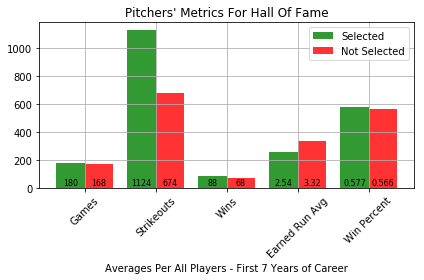

In [71]:
n_groups = 5
means_no  = X_graph_grouped.iloc[0, [2, 4, 5, 1, 3]]
means_yes = X_graph_grouped.iloc[1, [2, 4, 5, 1, 3]]

# create plot
fig, ax = plt.subplots()
index = np.arange(n_groups)
bar_width = 0.4
opacity = 0.8

rects1 = plt.bar(index, means_yes, bar_width,
alpha=opacity,
color='g',
label='Selected')

rects2 = plt.bar(index + bar_width, means_no, bar_width,
alpha=opacity,
color='r',
label='Not Selected')

plt.xlabel('Averages Per All Players - First 7 Years of Career')
plt.title("Pitchers' Metrics For Hall Of Fame")
plt.xticks(index + (bar_width/2), ('Games', 'Strikeouts', 'Wins', 'Earned Run Avg', 'Win Percent' ), rotation=45)
plt.grid()
plt.legend()

# Use functions to label the percentages of changes
def valuelabel(rects, ptext):

    x = 0
    for rect in rects:
        height = rect.get_height()
        if height > 10:
            ypos = 2
        elif height > 0:
            ypos = height + 1   # not enough room in the bar, so display just over it
        elif height > -10:
            ypos = height - 5
        else:
            ypos = -6
            
        plt.text(rect.get_x() + rect.get_width() / 2, ypos, ptext[x], ha="center", va="bottom", fontsize=8)
        x += 1
 

# reverse the above rescaling so that we can show true values
means_yes[3] = means_yes[3] / 100
means_yes[4] = means_yes[4] / 1000

# Call function to implement value labeling
chgx = pd.Series(["{:.0f}".format(means_yes[0]),
                  "{:.0f}".format(means_yes[1]),
                  "{:.0f}".format(means_yes[2]),
                  "{:.2f}".format(means_yes[3]),
                  "{:.3f}".format(means_yes[4]),
                 ])
valuelabel(rects1, chgx)

means_no[3] = means_no[3] / 100
means_no[4] = means_no[4] / 1000

chgx = pd.Series(["{:.0f}".format(means_no[0]),
                  "{:.0f}".format(means_no[1]),
                  "{:.0f}".format(means_no[2]),
                  "{:.2f}".format(means_no[3]),
                  "{:.3f}".format(means_no[4]),
                 ])

valuelabel(rects2, chgx)

plt.tight_layout()

In [72]:
# Save the Figure
plt.savefig("pitchers_metrics.png", bbox_inches="tight")

<Figure size 432x288 with 0 Axes>

In [ ]:
#pitching3_df.to_csv("db/pitching3_new.csv", index=False, header=True)

In [ ]:
#pitching4_df.to_csv("db/pitching4_new.csv", index=False, header=True)
#pitching_recent_df.to_csv("db/pitching_recent_new.csv", index=False, header=True)